In [65]:
import requests as req
from bs4 import BeautifulSoup
import json
import pandas as pd
from standardize import *
from key import api_key
from key import g_api_key
import re
import os
import bokeh as bo
import numpy as np 
import matplotlib as mp
from helper import *
import geopandas as gp
from shapely.geometry import Point

In [4]:
ln_list = ['rats','rat','mice','mouse',\
'racoon','racoons','possum','vermin','rodent','rodents','roach','roaches','cockroach','cockroaches','termite','termites']

url_sql = "https://data.milwaukee.gov/api/3/action/datastore_search?resource_id"

rats_endpoint = "resource_id=bf2b508a-5bfa-49da-8846-d87ffeee020a&q=rats"

historical = 'bf2b508a-5bfa-49da-8846-d87ffeee020a'
current = 'abdfe983-e856-40cd-bee2-85e78454344a'

df = pd.DataFrame()  #pull_data(url_sql, rats_endpoint, api_key)

for rec_id in [historical, current]:
    for rodent_end in ln_list:
        rodent_endpoint = '='+rec_id+'&q='+rodent_end
        new_df = pull_data(url_sql,rodent_endpoint,api_key)
        new_df['lookup_term'] = rodent_end
        df = df.append(new_df)

#df.drop_duplicates(inplace=True)

offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset0


/Users/ayaspan/anaconda3/envs/mke_calls/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset0
True
offset50000
True
offset0
True
offset50000
True
offset0
True
offset50000
True


In [5]:
df.shape

(2645, 8)

In [6]:
df.iloc[18].CASECLOSUREREASONDESCRIPTION

"Record number 3096518 is a request for Sanitation - *field only* Illegal Dumping. This request was entered into DPW's database on 2018-07-19 00:02:00.0. This record was given to a Sanitation crew on 2018-07-19 06:14:01.0. Sanitation has marked this request as 'Completed' on 2018-07-19 14:55:21.0. If you feel that this matter is NOT resolved, please call the CallCenter staff at (414)286-CITY(2489).THERE IS A LARGE GARBAGE AREA MY NEIGHBOR HAS NEXT TO MY BEDROOM WINDOW, WITH RAW EGGS, FOOD STUFF, AND GARBAGE HE SAYS IS A COMPOST PILE.IT IS NOT CONTAINED, I NOTICED RATS AND AN AWFUL SMELL."

In [7]:
df.head()

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,lookup_term,rank
0,Record number 2991342 is a request for Sanitat...,2018-01-09 13:08:32,2018-01-04 16:56:31,7820 W TOWNSEND ST,Cart Requests - Garbage Web,223850.0,rats,0.057309
1,Record number 3164787 is a request for Sanitat...,2018-11-27 10:31:13,2018-11-20 15:05:54,1115 E WRIGHT ST,Tree Trimming Web,16773.0,rats,0.057309
2,Record number 3162955 is a request for Sanitat...,2018-11-19 11:20:37,2018-11-15 13:11:44,5910 N 37TH ST,Call Back Sanitation Web,19040.0,rats,0.057309
3,Record number 3154445 is a request for Sanitat...,2018-11-09 09:46:37,2018-10-26 11:19:48,1337 N 55TH ST,Cart Requests - Garbage Web,29082.0,rats,0.057309
4,Record number 3149741 is a request for Sanitat...,2018-10-18 10:05:35,2018-10-16 11:58:51,3835 N 79TH ST,Cart Requests - Garbage Web,34999.0,rats,0.057309


In [8]:
cols = list(df.columns)
cols.remove('lookup_term')

In [9]:
df = df.groupby(cols).apply(lambda x: ','.join(x.lookup_term)).to_frame().reset_index().rename(columns={'0':'cats'})

In [10]:
df.rename(columns={0:'categories'},inplace=True)

In [11]:
df.head()

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,rank,categories
0,,2011-11-16 08:15:26,2011-10-26 20:27:57,3820 N HUMBOLDT BL,Rats Or Rat Harborage,1269755.0,0.057309,"rats,rat"
1,,2011-12-01 08:15:28,2011-11-24 19:03:40,2123 N 47TH ST,Rats Or Rat Harborage,1268704.0,0.057309,"rats,rat"
2,,2011-12-01 08:15:29,2011-11-24 19:08:25,4712 W LLOYD ST,Rats Or Rat Harborage,1268702.0,0.057309,"rats,rat"
3,,2012-02-20 09:59:58,2011-12-24 23:41:44,2904 W WISCONSIN AV # 101,Rats Or Rat Harborage,1266568.0,0.057309,"rats,rat"
4,,2012-02-21 08:16:54,2012-02-02 18:17:51,4712 W LLOYD ST,Rats Or Rat Harborage,1260196.0,0.057309,"rats,rat"


In [15]:
titles_df = df.groupby('TITLE').size().to_frame().reset_index().rename(columns={0:'cts','TITLE':'issue'}).sort_values('cts', ascending=False)
tt_5 = titles_df[:5]

In [16]:
categories_df = df.groupby('categories').size().to_frame().reset_index().rename(columns={0:'cts'}).sort_values('cts', ascending=False)

In [18]:
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from math import pi


output_notebook()
#output_file('vbar.html')

#data = {'issues': list(tt_5.issues), 'cts': np.ndarray(tt_5.cts)}

source = ColumnDataSource(data=dict(issue=tt_5.issue, cts=np.array(tt_5.cts)))

issue = source.data['issue'].tolist()

#print(dict(issues=list(tt_5.issue), cts=np.array(tt_5.cts)))

p = figure(x_range=tt_5.issue,plot_width=400, plot_height=400,toolbar_location=None)
p.vbar(x='issue', width=.9, bottom=0, source = source,
        top='cts', fill_color=factor_cmap('issue', palette=Spectral6, factors=tt_5.issue))
p.xaxis.major_label_orientation = pi/2.7
#p.vbar(x =titles_df.issue, width=0.5, top = titles_df.cts, bottom=0,color="firebrick")
show(p)


Loading BokehJS ...

In [19]:
df[df.TITLE=='Mice/Roach Infestation']

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,rank,categories


In [22]:
tc_5.head()

,categories,cts
11,possum,1005
36,rodents,321
13,racoon,285
16,rat,275
22,rats,216


In [23]:
tc_5 = categories_df[:5]

source = ColumnDataSource(data=dict(categories=tc_5.categories, cts=np.array(tc_5.cts)))

issue = source.data['categories'].tolist()

p = figure(x_range=tc_5.categories, plot_width=400, plot_height=400,toolbar_location=None)
p.vbar(x='categories', width=.9, bottom=0, source = source,
        top='cts', fill_color=factor_cmap('categories', palette=Spectral6, factors=tc_5.categories))
p.xaxis.major_label_orientation = pi/2.7
#p.vbar(x =titles_df.issue, width=0.5, top = titles_df.cts, bottom=0,color="firebrick")
show(p)

In [92]:
#c(" AV ", " DR ", " ST ", " RD ", " BL ", " PL ",
#                    " LA ", " CR ", " WA ", " CT ", " TR ", " PK ")
#http://maps2.milwaukee.gov/ArcGIS/rest/services/geocode/MAIthenDIME_geocode/GeocodeServer/findAddressCandidates?Street=3820+North+Humboldt+BL&SingleLine=&outFields=Loc_name&outSR=&f=json
import json
from bs4 import BeautifulSoup

def geo_locate(x):
    if not len(x):
        return [None,None]
    gl = "http://maps2.milwaukee.gov/ArcGIS/rest/services/geocode/MAIthenDIME_geocode/GeocodeServer/findAddressCandidates?Street="
    address = x.replace(' ','+')
    response = req.get(gl+address+'&SingleLine=&outFields=Loc_name&outSR=&f=json')
    if 'html' in str(response.content):
        soup = BeautifulSoup(response.content,'html.parser')
        #print(soup)
        #for i in soup.find('ul'):
        return re.findall(r'[0-9/.]+',soup.find('ul').text)
    else:
        #print(address)
        #print(response.content)
        res = response.json()
        if not len(res['candidates']):
            return [None,None]
        #print(res)
        result = res['candidates'][0]
        #print(result)
        geodata = dict()
        geodata['lat'] = result['location']['x']
        geodata['lng'] = result['location']['y']
        geodata['address'] = result['address']
        print(geodata['address'])
    return [geodata['lat'], geodata['lng']]

In [93]:
df['utm'] = df.OBJECTDESC.apply(lambda x: geo_locate(x))

3820 N HUMBOLDT BL
2123 N 47TH ST
4712 W LLOYD ST
4712 W LLOYD ST
2123 N 47TH ST
2301 W MC KINLEY AV
1335 N 43RD ST
8500 W TOWNSEND ST
4807 W LUSCHER AV
3924 N 77TH ST
431 N 34TH ST
3171 N 88TH ST
3721 N 4TH ST
2945 N 21ST ST
3951 N 20TH ST
624 E LOCUST ST
3070 N 1ST ST
1037 E OHIO AV
8216 W LISBON AV
3927 S 58TH ST
2943 N 21ST ST
140 E GAUER CR
6626 W OKLAHOMA AV
6632 W OKLAHOMA AV
4909 N 46TH ST
3761 S 91ST ST
3811 N 92ND ST
6248 W LEON TR
3480 S 63RD ST
2129 S 35TH ST
8341 W LISBON AV
3018 N 54TH ST
3002 N 74TH ST
1919 N 2ND ST
2408 S 7TH ST
3361 S 75TH ST
9522 W BELOIT RD
9514 W BELOIT RD
2924 S 57TH ST
3683 S 68TH ST
3708 N 56TH ST
2417 S HOWELL AV
2335 S 31ST ST
2822 N DOWNER AV
1547 N 18TH ST
5306 W CENTER ST
2605 W JUNEAU AV
3228 N 84TH ST
9507 W CAPITOL DR
8209 W CUSTER AV
6818 W MORGAN AV
2207 S WOODWARD ST
1847 N 2ND ST
6276 N 84TH ST
5931 N 60TH ST
2857 S 69TH ST
3693 S 68TH ST
3138 N 16TH ST
2604 W CAPITOL DR
2321 N 54TH ST
7417 W EDEN PL
2630 N 37TH ST
3706 N 23RD ST
3017

7600 W CAPITOL DR
2225 S WOODWARD ST
6427 W MEDFORD AV
1240 S 22ND ST
3579 S CLEMENT AV
6761 N 76TH ST
2433 W KILBOURN AV
2724 N 55TH ST
6029 N 38TH ST
1918 W GRANT ST
3916 N 10TH ST
2725 W FAIRMOUNT AV
3920 N 10TH ST
3916 N 10TH ST
2637 N SUMMIT AV
2678 N HUBBARD ST
203 E OHIO AV
3127 N 54TH ST
2401 N 1ST ST
2249 W BOLIVAR AV
2637 N SUMMIT AV
3240 N 84TH ST
4637 N 38TH ST
2085 W OKLAHOMA AV
4057 N 26TH ST
3427 N RIPON PL
4060 N 26TH ST
4060 N 60TH ST
1322 S 19TH ST
3751 N 9TH ST
2926 N 80TH ST
1015 S 15TH ST
3776 N 77TH ST
327 S 65TH ST
624 S 61ST ST
1336 N 32ND ST
3903 N 92ND ST
6929 W HERBERT AV
8115 W HAMPTON AV
1015 S 18TH ST
3946 S 1ST PL
3905 S 1ST PL
2214 S 20TH ST
4660 N 19TH PL
4696 W SCRANTON PL
6244 N 95TH ST
1336 N 32ND ST
3537 N 58TH BL
2523 W KILBOURN AV
429 N 33RD ST
2503 W CLYBOURN ST
1652 S 25TH ST
1540 W FOND DU LAC AV
3301 W ST PAUL AV
5200 W SILVER SPRING DR
3356 S 58TH ST
3233 N 81ST ST
3930 N 44TH ST
8026 W MEDFORD AV
2422 W MITCHELL ST
6611 N 55TH ST
1307 E SAVE

7910 W POTOMAC AV
7921 W CONGRESS ST
4222 N 87TH ST
1404 W STATE ST
4811 W WASHINGTON BL
4225 W PECK PL
3201 W NATIONAL AV
3930 W MANITOBA ST
3819 N 4TH ST
2749 N HOLTON ST
3815 S 13TH ST
4067 N 42ND ST
4020 W BURLEIGH ST
4854 N 57TH ST
3201 S 98TH ST
2937 N 77TH ST
7829 W CALDWELL CT
1658 S 21ST ST
4576 N 30TH ST
1902 E IRON ST
3331 S 35TH ST
6640 W MORGAN AV
4840 W SCRANTON PL
2969 N 46TH ST
8002 W GLENBROOK RD
1633 N 37TH ST
3551 N 13TH ST
3026 N OAKLAND AV
3545 S 23RD ST
3405 S 71ST ST
2506 S 28TH ST
7306 W CUSTER AV
5075 N 47TH ST
5700 W CLEVELAND AV
4600 W FOREST HOME AV
8019 W MARION ST
2400 W BURLEIGH ST
4306 N SHERMAN BL
3306 S 15TH PL
8922 W WINFIELD AV
5328 W GALENA ST
5200 N 68TH ST
4219 W CONCORDIA AV
3212 N 30TH ST
3051 N OAKLAND AV
1923 S 30TH ST
1619 S 11TH ST
4448 W MEDFORD AV
2925 N 79TH ST
3737 N 97TH ST
4266 N 42ND ST
5922 W ROOSEVELT DR
6639 N BOURBON ST
7800 W FOND DU LAC AV
6639 N BOURBON ST
3509 W PIERCE ST
5010 N 91ST ST
5246 N 69TH ST
5663 S HONEY CREEK DR
130

522 N 33RD ST
4062 S 76TH ST
4806 W HAMPTON AV
3129 W SCOTT ST
3069 N 6TH ST
3348 N 23RD ST
8667 W MEDFORD AV
3916 N 93RD ST
3911 N 93RD ST
918 N 26TH ST
1240 W FOND DU LAC AV
2014 W CONCORDIA AV
2644 N RICHARDS ST
5530 N 34TH ST
2949 N 12TH ST
5514 N 34TH ST
3049 N 46TH ST
6001 W BURLEIGH ST
2446 S 12TH ST
4423 N 30TH ST
3059 N 61ST ST
2035 N KILLIAN PL
2529 W AUER AV
3802 N 22ND ST
4050 N 92ND ST
4822 N 51ST BL
5210 W WISCONSIN AV
2144 N 49TH ST
4191 N 19TH ST
7820 W HAMPTON AV
4105 N 90TH CT
6570 N 53RD ST
3515 N 12TH ST
5524 N 103RD ST
3239 W MC KINLEY BL
3243 W MC KINLEY BL
5563 N 34TH ST
139 N 75TH ST
4143 N 67TH ST
164 N 69TH ST
3905 N MARTIN L KING JR DR
3245 S 24TH ST
4233 W SIEBEN PL
3135 S HANSON AV
4536 N 23RD ST
7804 W LOLITA AV
6780 W APPLETON AV
814 E KILBOURN AV
4154 N 48TH ST
2216 N BUFFUM ST
3032 N CAMBRIDGE AV
3909 N 75TH ST
2523 W ATKINSON AV
1915 S 7TH ST
4723 W VILLARD AV
6210 W MORGAN AV
4164 N 41ST ST
2524 W GARFIELD AV
3145 N 38TH ST
5941 W PARK HILL AV
6608 W 

400 N 92ND ST
3708 S 15TH PL
3701 S 15TH PL
2753 S 43RD ST
3848 N 83RD ST
3707 S 15TH PL
3215 N HUMBOLDT BL
2920 N 56TH ST
3431 S KINNICKINNIC AV
3054 N OAKLAND AV
1553 S 3RD ST
5571 N LONG ISLAND DR
1601 S 30TH ST
5330 W ROOSEVELT DR
2226 N 57TH ST
5215 N 62ND ST
2042 E LAFAYETTE PL
2618 N OAKLAND AV
2410 W HOPKINS ST
2360 E OKLAHOMA AV
5812 W HADLEY ST
2040 E LAFAYETTE PL
3220 S 68TH ST
1924 N 48TH ST
6523 W FREMONT PL
2429 W MEINECKE AV
3227 S 55TH ST
2353 N FARWELL AV
7130 W CHAMBERS CT
2528 S 11TH ST
5735 N 58TH ST
3229 N 21ST ST
2415 N 46TH ST
4073 N 46TH ST
2249 S 35TH ST
2130 W FOREST HOME AV
4429 N 56TH ST
1218 W HIGHLAND AV
5762 N 78TH ST
4745 W LEON TR
4732 N 40TH ST
2949 N 14TH ST
1823 E BRADFORD AV
3074 N TEUTONIA AV
3700 W BURLEIGH ST
8126 W LYNMAR TR
4126 N 50TH ST
2358 S HOWELL AV
3601 W NASH ST
1813 N 53RD ST
3562 N 11TH ST
2844 N 17TH ST
2040 E LAFAYETTE PL
3421 S 9TH PL
4642 N 42ND ST
2332 W HOWARD AV
4254 S WHITNALL AV
7252 W VAN BECK AV
2358 S HOWELL AV
2514 W MINE

In [94]:
df['easting'] = df.utm.apply(lambda x: float(x[0]) if x[0] !=None else None)
df['northing'] = df.utm.apply(lambda x: float(x[1]) if x[1] !=None else None)
df['point'] = df.utm.apply(lambda x: Point([float(x[0]),float(x[1])]) if x[1] !=None else None)

In [95]:
df.drop(['lat_long'], axis=1, inplace=True)
df.head()

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,rank,categories,easting,northing,point,utm
0,,2011-11-16 08:15:26,2011-10-26 20:27:57,3820 N HUMBOLDT BL,Rats Or Rat Harborage,1269755.0,0.057309,"rats,rat",2.561755e+06,403103.537342,POINT (2561754.957419626 403103.5373421761),"[2561754.957419626, 403103.5373421761]"
1,,2011-12-01 08:15:28,2011-11-24 19:03:40,2123 N 47TH ST,Rats Or Rat Harborage,1268704.0,0.057309,"rats,rat",2.541781e+06,392078.297672,POINT (2541780.910462635 392078.2976715099),"[2541780.9104626346, 392078.2976715099]"
2,,2011-12-01 08:15:29,2011-11-24 19:08:25,4712 W LLOYD ST,Rats Or Rat Harborage,1268702.0,0.057309,"rats,rat",2.541735e+06,391957.441261,POINT (2541734.713959598 391957.4412612302),"[2541734.7139595975, 391957.4412612302]"
3,,2012-02-20 09:59:58,2011-12-24 23:41:44,2904 W WISCONSIN AV # 101,Rats Or Rat Harborage,1266568.0,0.057309,"rats,rat",2.547778e+06,385434.097020,POINT (2547778.061870307 385434.0970203633),"[2547778.061870307, 385434.0970203633]"
4,,2012-02-21 08:16:54,2012-02-02 18:17:51,4712 W LLOYD ST,Rats Or Rat Harborage,1260196.0,0.057309,"rats,rat",2.541735e+06,391957.441261,POINT (2541734.713959598 391957.4412612302),"[2541734.7139595975, 391957.4412612302]"


In [96]:
df.to_csv('rodents.csv')

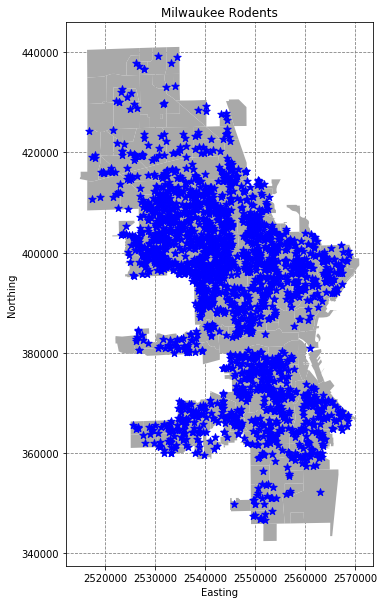

In [98]:
mil_link= 'neighborhood2.shp'
mil = gp.read_file(mil_link)
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

#colors
#https://matplotlib.org/gallery/color/colormap_reference.html

#cmap = ListedColormap(['winter'], name='winter')

fig,ax = plt.subplots(1, 1, figsize=(20,10))
mil.plot(color='darkgrey', ax =ax)

event_locs = gp.GeoDataFrame(df[['point']],
                            crs=mil.crs).rename(columns={'point':'geometry'})

event_locs.plot(ax=ax, 
                                color = 'blue', 
                                marker = '*',
                                markersize = 60)

ax.set(xlabel = 'Easting',
      ylabel='Northing',
      title="Milwaukee Rodents")
ax.set_axisbelow(True)
ax.yaxis.grid(color ='gray',
             linestyle='dashed')
ax.xaxis.grid(color ='gray',
             linestyle='dashed')
